In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import json
import pickle
# import dask

from concurrent.futures import ProcessPoolExecutor, as_completed


import discretize 
from simpeg import maps
from simpeg.electromagnetics import time_domain as tdem
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation#, DaskMetaSimulation

In [2]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

In [3]:
# directory = "./synthetic-data-10m"

# set up models and mesh

In [4]:
rho_back = 500
sigma_back = 1./rho_back 

rho_target = 20
sigma_target = 1./rho_target

sigma_air = 1e-8

target_dips = np.r_[0] #, 15, 30, 45]
target_z = np.r_[-200, -20]

In [5]:
tx_height = np.r_[30]

# rx_x = (np.linspace(-500, 500, 51) + 5)
# rx_x = (np.linspace(-510, 500, 102) + 5)
rx_x = np.linspace(-110, 100, 22) + 5
rx_x = rx_x[::2]
# rx_x = np.linspace(-70, 60, 12) + 5

rx_y = np.r_[0]
rx_z = tx_height

rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])
rx_x

array([-105.,  -85.,  -65.,  -45.,  -25.,   -5.,   15.,   35.,   55.,
         75.,   95.])

In [6]:
base_cell_width = 10
domain_extent = 8000

n_base_cells = 2 ** int(
    np.ceil(np.log(domain_extent / base_cell_width) / np.log(2.0))
)  # needs to be powers of 2 for the tree mesh

h = [(base_cell_width, n_base_cells)]
mesh = discretize.TreeMesh([h, h, h], origin="CCC", diagonal_balance=True)

# refine near transmitters and receivers
mesh.refine_points(
    rx_locs, level=-2, padding_cells_by_level=[2, 2, 4], 
    finalize=False, diagonal_balance=True
)

# Refine core region of the mesh 

bounding_points = np.array([
    [-105, rx_y.min(), target_z.min() - base_cell_width * 4], 
    [105, rx_y.max(), 0],
])
mesh.refine_bounding_box(
    bounding_points, level=-2, 
    diagonal_balance=True, finalize=False, padding_cells_by_level=[2, 8, 8]
)

mesh.finalize()

In [7]:
mesh

OcTreeMesh: 0.00% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  3   :       448            ---------------------------   --------------------
  4   :       296         x:    -5120.0   ,   5120.0          20.0   ,   1280.0  
  5   :      1152         y:    -5120.0   ,   5120.0          20.0   ,   1280.0  
  6   :      1668         z:    -5120.0   ,   5120.0          20.0   ,   1280.0  
  7   :      21960     
  8   :      12160     
  9   :      2560      
-----------------------
Total :      40244

In [8]:
# mesh.save(f"{directory}/treemesh.json")

In [9]:
def dipping_target_indices(
    mesh, target_x_center, target_z_center, dip, target_thickness, target_xlim=None, target_ylim=None, target_zlim=None
): 
    """
    add a dipping target to the model. For now assumes the target dips in the x-direction
    """
    x_center = np.mean(target_x)
    slope = np.tan(-dip*np.pi/180)
    target_z = target_z_center + target_thickness / 2 * np.r_[-1, 1]
    
    z_bottom = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.min()
    z_top = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.max()

    indices = (
        (mesh.cell_centers[:, 2] >= z_bottom) &
        (mesh.cell_centers[:, 2] <= z_top) 
    )

    if target_xlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 0] >= target_xlim.min()) &
            (mesh.cell_centers[:, 0] <= target_xlim.max())
        )
    if target_ylim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 1] >= target_ylim.min()) &
            (mesh.cell_centers[:, 1] <= target_ylim.max())
        )
    if target_zlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 2] >= target_zlim.min()) &
            (mesh.cell_centers[:, 2] <= target_zlim.max())
        )
    return indices

In [10]:
models = {}

target_x = np.r_[-30, 30]
target_y = np.r_[-500, 500]
target_z_center = -30
target_thickness = 40

# background model
background = np.ones(mesh.n_cells) * sigma_air
background[mesh.cell_centers[:, 2] < 0] = sigma_back
models["background"] = background

for dip in target_dips:
    model = background.copy()
    indices = dipping_target_indices(
        mesh, target_x_center=-100, target_z_center=target_z_center, 
        target_thickness=target_thickness, dip=dip, 
        target_xlim=target_x, 
        target_ylim=target_y,
        target_zlim=target_z
    )
    model[indices] = sigma_target
    models[f"target_{dip}"] = model



In [11]:
models

{'background': array([2.e-03, 2.e-03, 2.e-03, ..., 1.e-08, 1.e-08, 1.e-08]),
 'target_0': array([2.e-03, 2.e-03, 2.e-03, ..., 1.e-08, 1.e-08, 1.e-08])}

In [12]:
# with open(f"{directory}/true-models.pkl", "wb") as f:
#     pickle.dump(models, f)


In [13]:
model_keys = list(models.keys())
model_keys

['background', 'target_0']

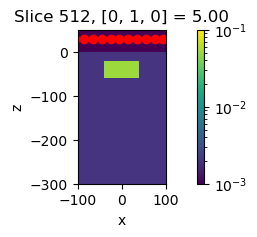

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2)) 

plt.colorbar(
    mesh.plot_slice(
        models["target_0"], 
        # grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        ax=ax)[0], 
    ax=ax
)

ax.set_xlim(100*np.r_[-1, 1])
ax.set_ylim(np.r_[-300, 50])

ax.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
ax.set_aspect(1)

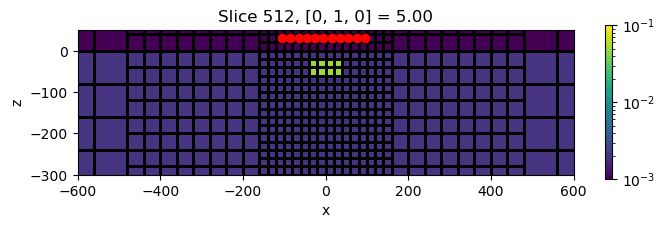

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2)) 

# mesh_local = mesh_list[-1]

plt.colorbar(
    mesh.plot_slice(
        models["target_0"], 
        grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        ax=ax)[0], 
    ax=ax
)

ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(np.r_[-300, 50])

ax.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
ax.set_aspect(1)


In [16]:
log_conductivity_models = {}

active_cells = mesh.cell_centers[:, 2] < 0

for key, val in models.items():
    log_conductivity_models[key] = np.log(val[active_cells])

In [17]:
rx_times = np.logspace(np.log10(1e-4), np.log10(8e-3), 27)[:20]
# np.savetxt(f"{directory}/rx_times.txt", rx_times)
# np.savetxt(f"{directory}/rx_locs.txt", rx_locs)
len(rx_times)

20

In [18]:
def get_sim():
    # set up survey
    source_list = []

    for i in range(rx_locs.shape[0]): 
        rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
        src = tdem.sources.CircularLoop(
            receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
            waveform=tdem.sources.StepOffWaveform()
        )
        source_list.append(src)
    
    survey = tdem.Survey(source_list)

    # create simulation 
    time_steps = [
        (1e-6, 30), (3e-6, 30), (1e-5, 30), (3e-5, 20), (1e-4, 20), #(3e-4, 20)
    ]      
    msh = mesh.copy()
    active_cells_map = maps.InjectActiveCells(msh, msh.cell_centers[:, 2]<0, value_inactive=np.log(1e-8))

    global_sim = tdem.simulation.Simulation3DElectricField(
        mesh=msh,
        survey=survey,
        time_steps=time_steps,
        solver=Solver,
        sigmaMap=maps.ExpMap() * active_cells_map
    )
    return global_sim

In [19]:
def run_simulation(key):
    print(f"Starting {key}")
    # filename = f"{directory}/{key}.txt"
    t = time.time()
    model = log_conductivity_models[key]
    sim = get_sim()
    dpred = sim.dpred(model)
    # np.savetxt(filename, dpred)
    elapsed = time.time() - t
    print(f".... done. {key}. Elapsed time = {elapsed:1.2e}s \n")
    return key, dpred

In [20]:
if __name__ == "__main__":
    dpred_dict = {}
    
    with ProcessPoolExecutor(max_workers=3) as executor:
        futures = [executor.submit(run_simulation, key) for key in model_keys]
        for future in as_completed(futures):
            key, dpred = future.result()
            dpred_dict[key] = dpred

Starting backgroundStarting target_0



/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/base/base_mesh.py:197: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  return cls(**items)
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/base/base_mesh.py:197: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  return cls(**items)


.... done. target_0. Elapsed time = 3.03e+02s 

.... done. background. Elapsed time = 3.06e+02s 



In [21]:
# %%time 

# dpred_dict = {}

# for key in model_keys:
#     print(f"Starting {key}")
#     filename = f"./synthetic-data/{key}.txt"
#     t = time.time()
#     model = log_conductivity_models[key]
#     sim = get_sim()
#     dpred = sim.dpred(model)
#     np.savetxt(filename, dpred)
#     dpred_dict[key] = dpred
#     print(f".... done. {filename}. Elapsed time = {time.time()-t:1.2e}s")
    
# # sim.join()

In [22]:
# dpred_dict

In [23]:
rx_locs.shape

(11, 3)

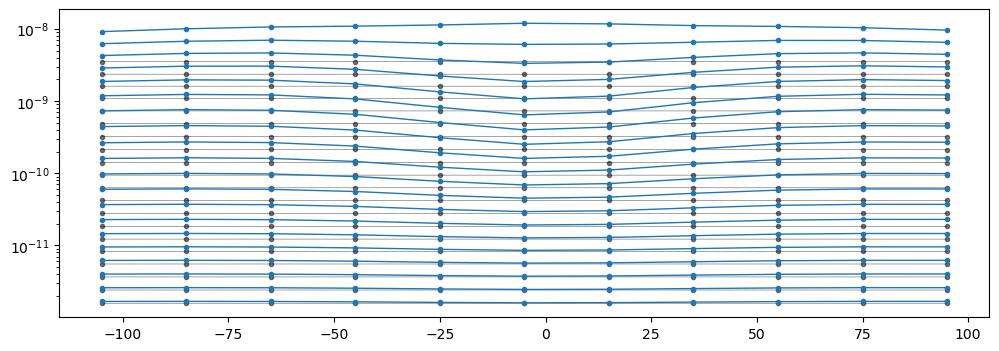

In [24]:
key = model_keys[1]
# rx_times = np.logspace(np.log10(1e-4), np.log10(8e-3), 27)

n_sources = rx_locs.shape[0]
n_rxtimes = len(rx_times)

fig, ax = plt.subplots(1, 1, figsize = (12, 4)) 

ax.semilogy(rx_x, -dpred_dict[model_keys[0]].reshape(n_sources, n_rxtimes), "-k", marker=".", lw=0.5, alpha=0.5);
ax.semilogy(rx_x, -dpred_dict[key].reshape(n_sources, n_rxtimes), "-C0", marker=".", lw=1);


In [25]:
global_sim = get_sim()
survey=global_sim.survey

/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/base/base_mesh.py:197: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  return cls(**items)


In [26]:
key = "target_0"
data_invert = Data(survey=survey, dobs=dpred_dict[key], relative_error=0.1, noise_floor=1e-11)

In [27]:
refine_depth = 120 # refine our local mesh to 200m 

def get_local_mesh(src):
    mesh_local = discretize.TreeMesh(mesh.h, origin=mesh.origin, diagonal_balance=True)
    refine_points = discretize.utils.ndgrid(
        np.r_[src.location[0]],
        np.r_[src.location[1]],
        np.linspace(-refine_depth, src.location[2], 40)
    )
    mesh_local.refine_points(
        refine_points,
        level=-2,
        padding_cells_by_level=[2, 4, 4],
        finalize=True,
        diagonal_balance=True
    )
    return mesh_local

with ProcessPoolExecutor() as executor:
    mesh_list = list(executor.map(get_local_mesh, survey.source_list))

In [28]:
mesh_list[0]

OcTreeMesh: 0.00% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  3   :       448            ---------------------------   --------------------
  4   :       448         x:    -5120.0   ,   5120.0          20.0   ,   1280.0  
  5   :       378         y:    -5120.0   ,   5120.0          20.0   ,   1280.0  
  6   :       772         z:    -5120.0   ,   5120.0          20.0   ,   1280.0  
  7   :      2212      
  8   :      1468      
  9   :       288      
-----------------------
Total :      6014

In [29]:
mappings = []
sims = []

active_cells_map = maps.InjectActiveCells(mesh, mesh.cell_centers[:, 2]<0, value_inactive=np.log(1e-8))
time_steps = [
    (1e-6, 30), (3e-6, 30), (1e-5, 30), (3e-5, 20), (1e-4, 20), #(3e-4, 20)
] 

for ii, local_mesh in enumerate(mesh_list):
    
    tile_map = maps.TileMap(mesh, active_cells_map.active_cells, local_mesh)
    mappings.append(tile_map)
    
    local_actmap = maps.InjectActiveCells(
        local_mesh, 
        active_cells=tile_map.local_active, 
        value_inactive=np.log(1e-8)
    )
    
    local_survey = tdem.Survey([survey.source_list[ii]])
    sims.append(tdem.simulation.Simulation3DElectricField(
            mesh=local_mesh,
            survey=local_survey,
            time_steps=time_steps,
            solver=Solver,
            sigmaMap=maps.ExpMap() * local_actmap
        )
    )



In [30]:
sim = MultiprocessingMetaSimulation(sims, mappings)

# client = dask.Client()
# sim = DaskMetaSimulation(sims, mappings, client=client)

/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/simpeg/meta/multiprocessing.py:229: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  super().__init__(simulations, mappings)
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/simpeg/meta/multiprocessing.py:248: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  sim_chunk = MetaSimulation(
Process _SimulationProcess-58:
Process _SimulationProcess-52:
Process _SimulationProcess-54:
Process _SimulationProcess-56:
Process _SimulationProcess-53:
Process _SimulationProcess-57:
Process _SimulationProcess-60:
Process _SimulationProcess-55:
Process _SimulationProcess-62:
Traceback (most recent call last):
Process _SimulationProcess-59:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lheagy/miniforge3/envs/py311/lib/python3.11/multiprocessing/process.py", line 314,

In [31]:
# relative_error=0.1
# noise_floor=1e-11
# alpha_s = 1e-1
# alpha_x = 1
rho_back = 500
# beta0 = 10


dmis = data_misfit.L2DataMisfit(simulation=global_sim, data=data_invert)
reg = regularization.WeightedLeastSquares(
    mesh, 
    active_cells=active_cells_map.active_cells,
)

opt = optimization.InexactGaussNewton(maxIter=20, maxIterCG=30, tolCG=1e-3)
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=2)

cool_beta = directives.BetaSchedule(coolingFactor=2, coolingRate=3)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputDictEveryIteration(
    saveOnDisk=False,
)

target_misfit = directives.TargetMisfit()

# The directives are defined as a list.
directives_list = [
    # sensitivity_weights,
    # update_jacobi,
    starting_beta,
    cool_beta,
    save_iteration,
    target_misfit,
]

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

In [32]:
m0 = np.log(1/rho_back) * np.ones(np.sum(active_cells_map.active_cells))

In [33]:
%%time
mrec = inv.run(m0)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DElectricField problem***
                        


KeyboardInterrupt: 

In [34]:
mlast = inv.invProb.model

(array([    0.,     0.,     0.,     0.,     0., 22964.,     0.,     0.,
            0.,     0.]),
 array([-3.19897, -3.09897, -2.99897, -2.89897, -2.79897, -2.69897,
        -2.59897, -2.49897, -2.39897, -2.29897, -2.19897]),
 <BarContainer object of 10 artists>)

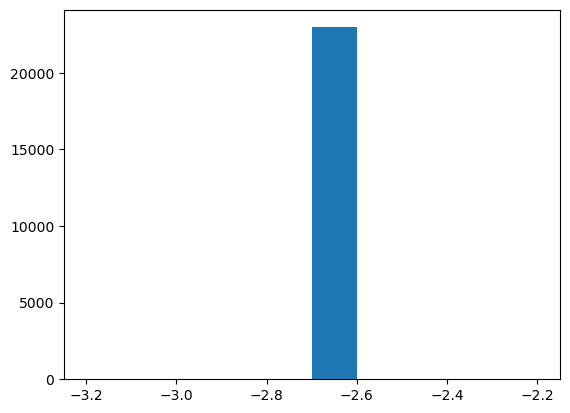

In [35]:
plt.hist(np.log10(np.exp(mlast)))

In [36]:
np.min(np.exp(mlast))

np.float64(0.0020000000000000005)

In [37]:
np.max(np.exp(mlast))

np.float64(0.0020000000000000005)

In [38]:
mrec

NameError: name 'mrec' is not defined